# Lecture 22: Gaussian Processes
AM207: Verena Kaynig-Fittkau,and Pavlos Protopapas, Harvard University


In [26]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
from IPython import display

Let us look at just this idea of having our points sampled from a joint distribution.

In [27]:
def get_cov_matrix(l, t, xx1,xx2):
    kernel = lambda x1,x2: t * np.exp(-((x1-x2)**2) / (2.0*l))

    sigma = np.zeros((xx1.shape[0],xx2.shape[0]))
    for i in xrange(xx1.shape[0]):
        for j in xrange(xx2.shape[0]):
            sigma[i,j] = kernel(xx1[i],xx2[j])
            
    return sigma

True


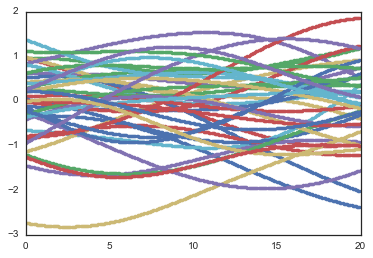

In [28]:
l = 100.0
t = 1.0
s = 300
xx = np.linspace(0,20,s)
sigma = get_cov_matrix(l,t,xx,xx) + np.eye(s)*0.00000001

# checking if positive definite
print np.all(np.linalg.eigvals(sigma) > 0)

for i in xrange(40):
    samples = np.random.multivariate_normal(np.zeros(s), sigma)
    plt.plot(xx, samples, '.')

Now we add some data:

In [29]:
# let's add a few data points

l = 5.0
t = 1.0
s = 300

x_star = np.linspace(1,20,s)

# defining the training data
x = np.array([5.0, 10.0, 15.0])
f = np.reshape([1.0, -1.0, -2.0],(3,1))

# now we need to get the conditional matrix given our data point
# variable names follow lecture notes

K = get_cov_matrix(l,t, x,x) 

K_star = get_cov_matrix(l,t, x,x_star)
K_star_star = get_cov_matrix(l,t,  x_star, x_star)
K_inv = np.linalg.inv(K)

In [30]:
mu_star = np.dot(np.dot(K_star.T, K_inv),f) 
sigma_star = K_star_star  - np.dot(np.dot(K_star.T, K_inv),K_star)

C:\Users\vkaynig\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: covariance is not positive-semidefinite.
  from ipykernel import kernelapp as app


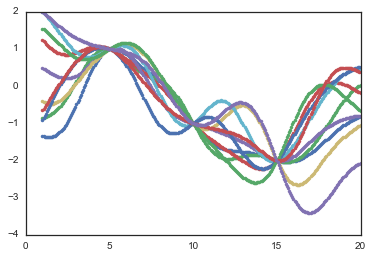

In [31]:
for i in xrange(10):
    samples = np.random.multivariate_normal(mu_star.flatten(), sigma_star)
    plt.plot(x_star, samples, '.')

For a better visualization we can directly plot the mean curve and a shaded area for the standard deviation

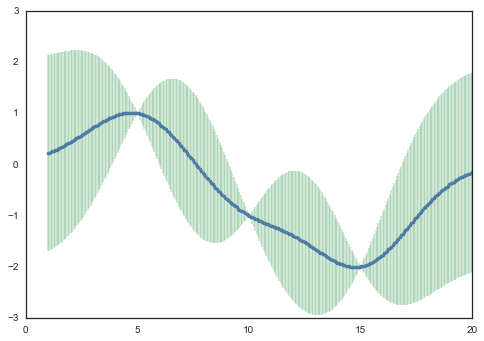

In [7]:
plt.plot(x_star, mu_star, '.')
plt.errorbar(x_star, mu_star, yerr=1.96*np.sqrt(sigma_star.diagonal()), alpha=0.3);

We are still in the noiseless scenario, so the GP goes directly through the data points we specified, and there is no uncertainty about our measurements. As you can see the further away from a data point the GP is making predictions, the more uncertainty we have. 

No let's add some noise to our scenario. We assume $y = f(x) + \epsilon$ with $\epsilon \sim N(0, \sigma_{\epsilon}^2)$

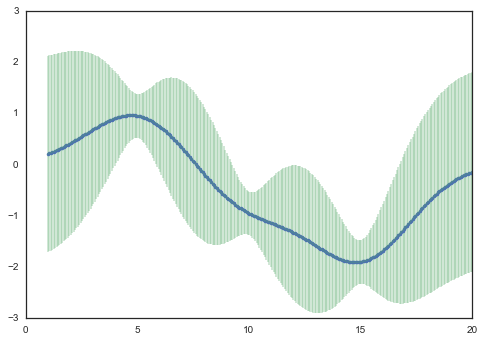

In [8]:
sigma_epsilon_sq = 0.05

K_noise = K + np.diag([sigma_epsilon_sq] * K.shape[0])  
K_noise_inv = np.linalg.inv(K_noise)

mu_star_noise = np.dot(np.dot(K_star.T, K_noise_inv),f) # the one comes from the f= 1.0 for our data point
sigma_star_noise = K_star_star  - np.dot(np.dot(K_star.T, K_noise_inv),K_star)

plt.plot(x_star, mu_star_noise, '.')
plt.errorbar(x_star, mu_star_noise, yerr=1.96*np.sqrt(sigma_star_noise.diagonal()), alpha=0.3);

Knowing that our measurements contain noise, makes us less certain, even if we observed some data. 

Let us also look at the numerically more stable version

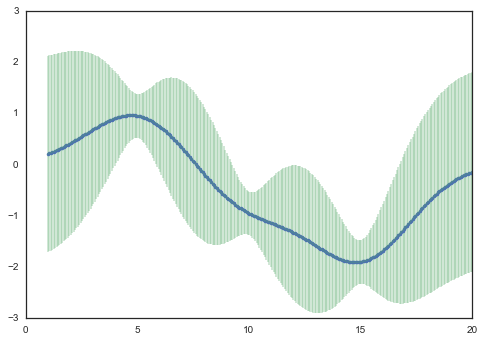

In [9]:
L = np.linalg.cholesky(K_noise)
#numpy.linalg.solve(a, b)
#Computes the “exact” solution, x, of the well-determined, i.e., full rank, linear matrix equation ax = b.
m = np.linalg.solve(L,f)
alpha = np.linalg.solve(L.T,m)
mu_star_noise_c = np.dot(K_star.T, alpha)

v = np.linalg.solve(L,K_star)
sigma_star_noise_c = K_star_star  - np.dot(v.T,v)


plt.plot(x_star, mu_star_noise_c, '.')
plt.errorbar(x_star, mu_star_noise, yerr=1.96*np.sqrt(sigma_star_noise_c.diagonal()), alpha=0.3);

### Thompson sampling

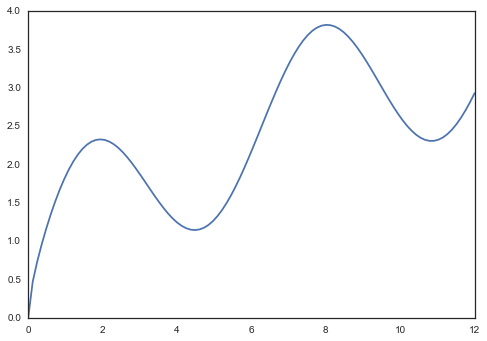

In [10]:
f_true = lambda x : np.sqrt(x) + np.sin(x) 
xx = np.linspace(0,12,100)

plt.plot(xx, f_true(xx))
plt.show()

C:\Users\vkaynig\Anaconda2\lib\site-packages\ipykernel\__main__.py:20: RuntimeWarning: covariance is not positive-semidefinite.


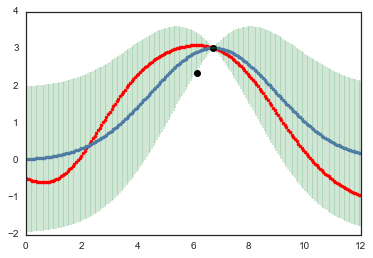

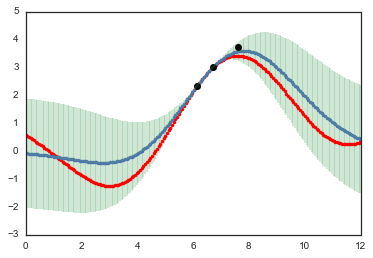

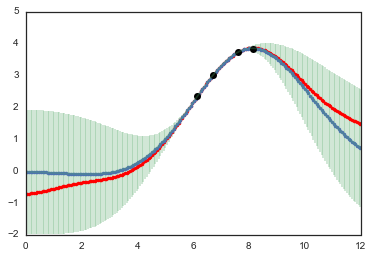

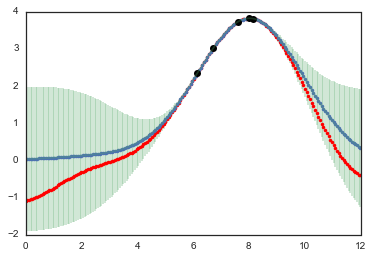

Learned nothing new.


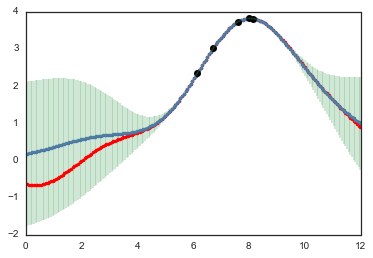

Learned nothing new.


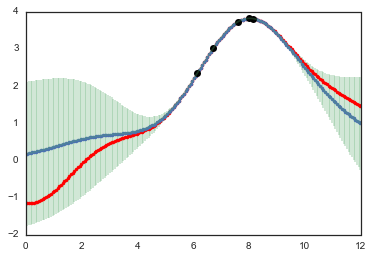

Learned nothing new.


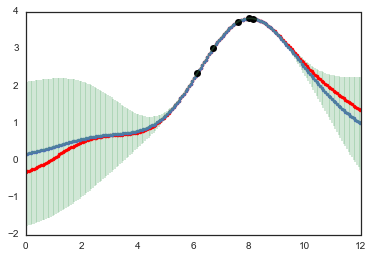

Learned nothing new.


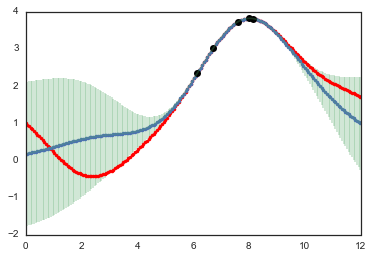

Learned nothing new.


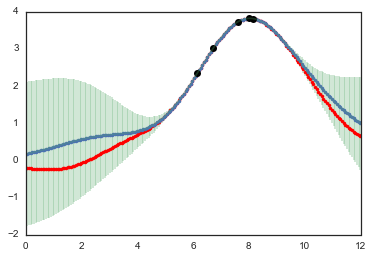

Learned nothing new.


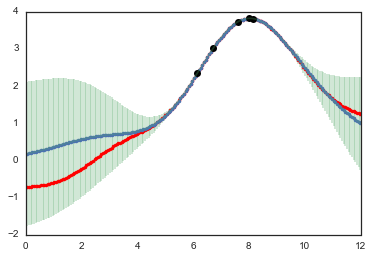

In [20]:
l = 5.0
t = 1.0
s = 200

x_star = np.linspace(0,12,s)

# definint the training data
x = np.array([np.random.random()*12.0])

for i in xrange(10):
    K = get_cov_matrix(l,t, x,x) 
    K_inv = np.linalg.inv(K)
    
    K_star = get_cov_matrix(l,t, x,x_star)
    K_star_star = get_cov_matrix(l,t,  x_star, x_star)
    
    mu_star = np.dot(np.dot(K_star.T, K_inv),f_true(x)) 
    sigma_star = K_star_star  - np.dot(np.dot(K_star.T, K_inv),K_star)
    
    samples = np.random.multivariate_normal(mu_star.flatten(), sigma_star)
    x_new = np.argmax(samples)
    
    #avoid singular matrix
    if not x_star[x_new] in x:
        x = np.append(x,x_star[x_new])
    else:
        print "Learned nothing new."
    
    plt.plot(x_star, samples, 'r.')    
    plt.plot(x_star, mu_star, '.')
    plt.plot(x, f_true(x), "ko")
    plt.errorbar(x_star, mu_star, yerr=1.96*np.sqrt(sigma_star.diagonal()), alpha=0.3);
    plt.xlim(0,12)
    plt.show()

    

### Probability of Improvement

<img src="GP_PI_EI.png" alt="" height="42">

Nando de Freitas, [Machine learning - Bayesian optimization and multi-armed bandits](https://www.youtube.com/watch?v=vz3D36VXefI&ebc=ANyPxKrwOE4b6TrHgXBAZrt4Gg5slFclMpDpFUS1jVmTxpt_gqgYdMPtM-yjM1KBJBHDFp79PpEzJzF5vUyqU5xB_X5jdO5ZKA)
